## Surveying the Global Refugee Crisis

Global Refugee and forced displacement caused by economic turmoil, social-political unrest, war, violence and natural disasters. Often countries that are hosting refugees are among the low-income group based on WDI reporting. 

"Host communities need support, too. The forcibly displaced often live in poor areas in developing countries that are struggling to meet their own development goals. Accommodating the sudden arrival of masses of newcomers presents a challenge for host governments, putting further pressure on their ability to deliver basic services and infrastructure." - The World Bank

<b>Scenario/Goal:</b> To bring awareness to the refugee crisis and promote support. 

<b>Deliverable:</b> A report on refugee statistics and the economic statuses of host countries and refugee countries. 

In-scope: 

1. Top 10 countries of host countries and refugee countries were selected for visualizations
2. Last 10 years

De-scoped: 

1. Poverty Indicators ('Population living in slums (% of urban population)' and Climate related Indicators 'CO2 emissions (metric tons per capita)' were considered, but were descoped due to limited data availability.

## Maxim: Not All Data is Equal

Depending on the indicators, some are more populated than others. Collection effort may vary among countries for the same indicators.  According to the WDI, "Statistical systems in many of the poorest countries are limited." (Ref: 
https://datatopics.worldbank.org/world-development-indicators/sources-and-methods.html) 



In [27]:
!pip install altair
!pip install vega_datasets

In [28]:
# Download and unzip files onto directory
"""
!wget http://databank.worldbank.org/data/download/WDI_csv.zip ./data
!unzip ./data/WDI_csv.zip -d ./data 
"""

'\n!wget http://databank.worldbank.org/data/download/WDI_csv.zip ./Oral Exam/data\n!unzip ./data/WDI_csv.zip -d ./data \n'

In [29]:
# Import Libraries
import pandas as pd
import numpy as np
import requests
import json
import altair as alt
from vega_datasets import data
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

starttime_now = datetime.now()
pd.set_option('display.max_columns', 500)


In [30]:
# Source: http://databank.worldbank.org/data/download/WDI_csv.zip
WDI_df = pd.read_csv('./data/WDIData.csv')
WDI_country_df = pd.read_csv('./data/WDICountry.csv')

# Source: https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes
iso_country = pd.read_csv('./data/country_code_ISO.csv')


## Data Cleaning and Manipulation

In [31]:
## Fetching Indicators of interest

ind = ['Refugee population by country or territory of asylum', 'Refugee population by country or territory of origin','GDP (current US$)','Population living in slums (% of urban population)','GDP growth (annual %)']
ind_code = ['SM.POP.REFG', 'SM.POP.REFG.OR','NY.GDP.MKTP.CD','EN.POP.SLUM.UR.ZS','NY.GDP.MKTP.KD.ZG']
ind_dict = dict(zip(ind_code,ind))

In [32]:
## Process WDI 

# subset to data of interest
df_2 = WDI_df[WDI_df['Indicator Code'].isin(list(ind_dict.keys()))]
del WDI_df

# Cleaning by Filter on countries instead of regions reported in Short Name
countries_to_filter_on = list(WDI_country_df[pd.notnull(WDI_country_df['Region'])]['Short Name'].unique())
df_2 = df_2[df_2['Country Name'].isin(countries_to_filter_on)]

# merge for 'Region' and 'Income Group'
df_2 = df_2.merge(WDI_country_df[['Country Code','Region','Income Group']], how='inner', on ='Country Code')
df_2 = df_2.merge(iso_country, how='inner', on ='Country Name')

# Remove unneeded column
df_2.drop(columns = ['Unnamed: 66'],inplace = True)



In [33]:
# Perform Group By Country and Indicators
df_3 = df_2.groupby(by = ['Indicator Name','Country Name']).sum().reset_index()

# GroupBy Region
df_7 = df_2.groupby(by = ['Region','Indicator Name']).sum().reset_index()

# Group By Income Group
df_8 = df_2.groupby(by = ['Income Group','Indicator Name']).sum().reset_index()
del df_2

In [34]:
# Perform Transpose
df_4 = pd.melt(df_3, id_vars = ['Indicator Name','Country Name','Code'])
del df_3

df_8_pivot = pd.melt(df_8.drop(['Code'], axis = 1), id_vars = ['Indicator Name','Income Group'])
del df_8

# Rename Column
df_4 = df_4.rename(columns={'variable':'year'})
df_8_pivot = df_8_pivot.rename(columns={'variable':'year'})

# Casting object to int
df_4 = df_4.astype({"year": int})
df_8_pivot = df_8_pivot.astype({"year": int})


In [35]:
# Post-Transpose Manipulations

# Filter on last 10 years. 
df_4 = df_4[df_4['year'] > 2009]
df_8_pivot = df_8_pivot[df_8_pivot['year'] > 2009]

df_4.reset_index(inplace = True)

## Correlation Analysis

In [36]:
# build correlation plot or create distributions. (could have pursued group by/unstacking)
df_6 = pd.pivot_table(df_4, index = ['Country Name','year'],columns = ['Indicator Name'],values = ['value'], aggfunc = np.sum).reset_index()
df_6.columns.to_flat_index()
df_6.columns = df_6.columns.get_level_values(0) + '_' +  df_6.columns.get_level_values(1)
df_6.rename(inplace = True, axis = 1,mapper = {'Country Name_':"Country Name", 'year_':'year','value_GDP growth (annual %)':'GDP growth (annual %)','value_GDP (current US$)': 'GDP (current US$)', 'value_Population living in slums (% of urban population)':'Population living in slums (% of urban population)','value_Refugee population by country or territory of asylum':'Refugee population by country or territory of asylum', 'value_Refugee population by country or territory of origin':'Refugee population by country or territory of origin'})
cormat = df_6.iloc[:,2:].corr()

df_10 = df_6.merge(WDI_country_df[['Short Name','Country Code','Region','Income Group']], how='inner', left_on ='Country Name', right_on = 'Short Name')
del WDI_country_df

cor_sub1 = df_10[df_10['Region'] == 'Europe & Central Asia'].iloc[:,2:7]
cormat1 = cor_sub1.corr()

cor_sub2 = df_10[df_10['Income Group'] == 'Low income'].iloc[:,2:7]
cormat2 = cor_sub2.corr()


Correlation Plot suggest low correlation among the indicators. Correlation is calculated by summing and squaring the residuals when variables are plot against each other. A scatterplot matrix (SPLOM) was considered, but removed due to appearing noisy. 

(5.0, 0.0)

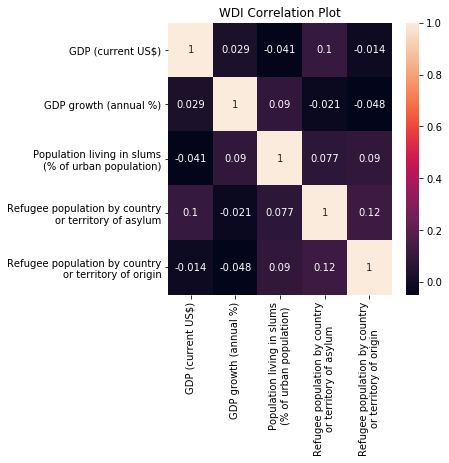

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.heatmap(cormat, annot = True)
ax.set(title="WDI Correlation Plot", xticklabels = ["GDP (current US$)","GDP growth (annual %)","Population living in slums\n(% of urban population)","Refugee population by country\nor territory of asylum","Refugee population by country\nor territory of origin"],yticklabels = ["GDP (current US$)","GDP growth (annual %)","Population living in slums\n(% of urban population)","Refugee population by country\nor territory of asylum","Refugee population by country\nor territory of origin"])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


Interestingly, by focusing on low income countries or a specific region, 'Europe & Central Asia' we see that "GDP (current US)" have a higher correlation with Refugee population by country or territory of asylum.  This agrees with our intuition that larger economies measured in GDP have the capacity to take on refugees. However, low-income countries still have a high correlation of 'GDP (current US$)' vs 'Refugee population by country or territory of asylum'. This may suggest that high GDP in the lower income bracket hosts refugees. In the next iteration of this report, I would consider label encoding income class and one-hot encode Region and then, apply pearson correlation. 

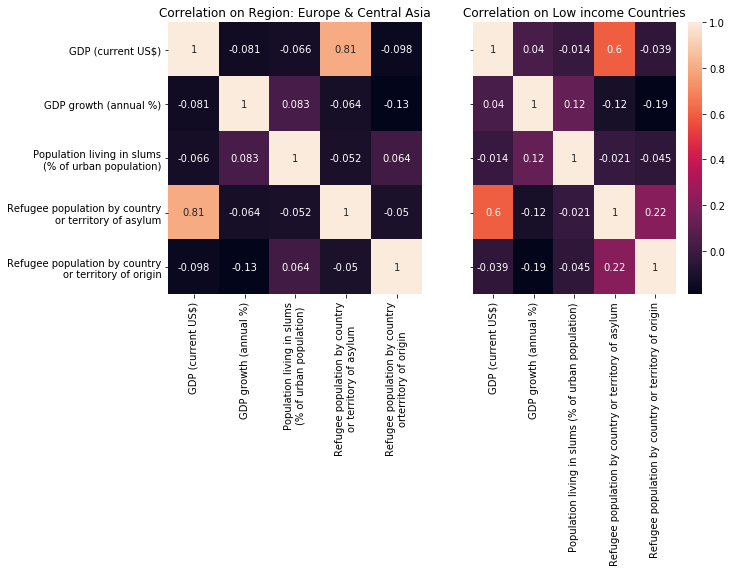

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1 = sns.heatmap(cormat1, annot = True, ax = ax1, cbar = False)
ax1.set(title="Correlation on Region: Europe & Central Asia", xticklabels = ["GDP (current US$)","GDP growth (annual %)","Population living in slums\n(% of urban population)","Refugee population by country\nor territory of asylum","Refugee population by country\norterritory of origin"],yticklabels = ["GDP (current US$)","GDP growth (annual %)","Population living in slums\n(% of urban population)","Refugee population by country\nor territory of asylum","Refugee population by country\nor territory of origin"])
bottom, top = ax1.get_ylim()
ax1.set_ylim(bottom + 0.5, top - 0.5)

ax2 = sns.heatmap(cormat2, annot = True)
ax2.set(yticklabels=[], title = "Correlation on Low income Countries")
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)

# Render Two subplots
plt.show()


To narrow the scope, I will focus on the top 10 countries where refugees are seeking asylum and the top countries were refugees are fleeing from.

In [39]:
# Pre-processing to narrow to countries of interest
df_5 = pd.pivot_table(df_4, values ='value', index = ['Country Name'], columns = ['Indicator Name'], aggfunc = np.mean).reset_index().rename({'CO2 emissions (metric tons per capita)':'avg(CO2 emissions (metric tons per capita))','GDP (current US$)':'avg(GDP (current US$))', 'GDP per capita (current US$)':'avg(GDP per capita (current US$))','Refugee population by country or territory of asylum':'avg(Refugee population by country or territory of asylum)','Refugee population by country or territory of origin':'avg(Refugee population by country or territory of origin)'}, axis = 'columns')

## top 10 countries where refugees are heading to.
top10_asylum = df_5.sort_values(by = ['avg(Refugee population by country or territory of asylum)'], ascending = False)['Country Name'][:10]
df_5.sort_values(by = ['avg(Refugee population by country or territory of asylum)'], ascending = False).head(10)

Indicator Name,Country Name,avg(GDP (current US$)),GDP growth (annual %),Population living in slums (% of urban population),avg(Refugee population by country or territory of asylum),avg(Refugee population by country or territory of origin)
85,Jordan,3.798829e+10,2.050097,6.416667,2.766120e+06,2.188750e+03
127,Pakistan,2.781496e+11,3.747781,14.416666,1.535354e+06,1.314828e+05
91,Lebanon,4.350004e+10,-2.048971,9.516666,1.194909e+06,7.602917e+03
171,Uganda,3.183584e+10,4.977818,17.458333,7.769842e+05,6.801833e+03
160,Syrian Arab Republic,4.022859e+10,-5.248081,6.041667,7.554643e+05,4.221069e+06
61,Germany,3.729372e+12,1.503116,0.001667,7.327407e+05,1.151667e+02
53,Ethiopia,6.901877e+10,9.123634,23.375001,6.323482e+05,9.348867e+04
156,Sudan,6.685227e+10,-1.002565,22.800000,5.686018e+05,6.513168e+05
14,Bangladesh,2.430836e+11,6.373057,17.775000,5.117048e+05,1.491867e+04
87,Kenya,7.576638e+10,4.801227,16.975000,4.876321e+05,8.043250e+03


In [40]:
## top 10 countries where refugees are coming from.
top10_origin = df_5.sort_values(by = ['avg(Refugee population by country or territory of origin)'], ascending = False)['Country Name'][:10]
df_5.sort_values(by = ['avg(Refugee population by country or territory of origin)'], ascending = False).head(10)

Indicator Name,Country Name,avg(GDP (current US$)),GDP growth (annual %),Population living in slums (% of urban population),avg(Refugee population by country or territory of asylum),avg(Refugee population by country or territory of origin)
160,Syrian Arab Republic,4.022859e+10,-5.248081,6.041667,755464.333333,4.221069e+06
0,Afghanistan,1.726548e+10,3.747895,17.058333,84986.916667,2.663876e+06
153,South Sudan,7.152278e+09,-3.293251,23.691667,236048.000000,1.212054e+06
151,Somalia,4.387704e+09,4.577439,24.408333,8780.666667,9.811829e+05
113,Myanmar,6.155812e+10,4.837752,12.808333,0.000000,7.337767e+05
156,Sudan,6.685227e+10,-1.002565,22.800000,568601.833333,6.513168e+05
78,Iraq,1.982649e+11,4.334027,16.008334,217563.833333,5.798240e+05
33,Central African Republic,2.129646e+09,-0.010629,31.841667,11335.583333,4.371272e+05
50,Eritrea,3.045431e+08,0.906166,0.000000,2437.333333,4.025115e+05
37,Colombia,3.238148e+11,3.388098,6.941667,426.416667,2.849124e+05


# Summary Statistics: 

- Refugee population by country or territory of asylum
- Refugee population by country or territory of origin


In [41]:
df_10.groupby(['year','Region'])['Refugee population by country or territory of asylum'].describe().unstack()

count                                                  \
Region East Asia & Pacific Europe & Central Asia Latin America & Caribbean   
year                                                                         
2010                  29.0                  49.0                      32.0   
2011                  29.0                  49.0                      32.0   
2012                  29.0                  49.0                      32.0   
2013                  29.0                  49.0                      32.0   
2014                  29.0                  49.0                      32.0   
2015                  29.0                  49.0                      32.0   
2016                  29.0                  49.0                      32.0   
2017                  29.0                  49.0                      32.0   
2018                  29.0                  49.0                      32.0   
2019                  29.0                  49.0                      32.0   
2020                  29.0                  49.0                      32.0   
2021                  29.0                  49.0                      32.0   

                                                                               \
Region Middle East & North Africa North America South Asia Sub-Saharan Africa   
year                                                                            
2010                         17.0           2.0        8.0               42.0   
2011                         17.0           2.0        8.0               42.0   
2012                         17.0           2.0        8.0               42.0   
2013                         17.0           2.0        8.0               42.0   
2014                         17.0           2.0        8.0               42.0   
2015                         17.0           2.0        8.0               42.0   
2016                         17.0           2.0        8.0               42.0   
2017                         17.0           2.0        8.0               42.0   
2018                         17.0           2.0        8.0               42.0   
2019                         17.0           2.0        8.0               42.0   
2020                         17.0           2.0        8.0               42.0   
2021                         17.0           2.0        8.0               42.0   

                      mean                                                  \
Region East Asia & Pacific Europe & Central Asia Latin America & Caribbean   
year                                                                         
2010          17818.275862          27592.632653                5356.15625   
2011          17775.413793          27335.673469                5463.56250   
2012          17973.758621          27926.897959                5503.78125   
2013          20217.689655          21055.693878                5521.40625   
2014          20157.241379          23766.204082                5563.62500   
2015          19326.862069          28538.061224                5091.00000   
2016          20013.241379          40262.959184                4665.43750   
2017          20815.310345          48487.775510                4012.65625   
2018          21658.000000          52642.938776                4609.00000   
2019          21143.793103          57285.244898                5914.03125   
2020          21119.620690          60865.795918                7482.90625   
2021          21316.586207          63416.326531                7148.71875   

                                                             \
Region Middle East & North Africa North America  South Asia   
year                                                          
2010                264684.117647       82772.0  301393.875   
2011                254872.823529       82439.5  274166.750   
2012                245231.000000       81875.5  265918.500   
2013                301877.235294       80173.5  262418.125   
2014                32

In [42]:
df_10.groupby(['year','Region'])['Refugee population by country or territory of origin'].describe().unstack()

count                                                  \
Region East Asia & Pacific Europe & Central Asia Latin America & Caribbean   
year                                                                         
2010                  29.0                  49.0                      32.0   
2011                  29.0                  49.0                      32.0   
2012                  29.0                  49.0                      32.0   
2013                  29.0                  49.0                      32.0   
2014                  29.0                  49.0                      32.0   
2015                  29.0                  49.0                      32.0   
2016                  29.0                  49.0                      32.0   
2017                  29.0                  49.0                      32.0   
2018                  29.0                  49.0                      32.0   
2019                  29.0                  49.0                      32.0   
2020                  29.0                  49.0                      32.0   
2021                  29.0                  49.0                      32.0   

                                                                               \
Region Middle East & North Africa North America South Asia Sub-Saharan Africa   
year                                                                            
2010                         17.0           2.0        8.0               42.0   
2011                         17.0           2.0        8.0               42.0   
2012                         17.0           2.0        8.0               42.0   
2013                         17.0           2.0        8.0               42.0   
2014                         17.0           2.0        8.0               42.0   
2015                         17.0           2.0        8.0               42.0   
2016                         17.0           2.0        8.0               42.0   
2017                         17.0           2.0        8.0               42.0   
2018                         17.0           2.0        8.0               42.0   
2019                         17.0           2.0        8.0               42.0   
2020                         17.0           2.0        8.0               42.0   
2021                         17.0           2.0        8.0               42.0   

                      mean                                                  \
Region East Asia & Pacific Europe & Central Asia Latin America & Caribbean   
year                                                                         
2010          22047.034483           8967.367347               14438.06250   
2011          22144.448276           8373.877551               14814.28125   
2012          22215.000000           8087.040816               15008.90625   
2013          24427.344828           3944.448980               15156.31250   
2014          24911.655172           8306.653061               14099.25000   
2015          24015.655172           9620.734694               13653.75000   
2016          25113.379310           7745.530612               12808.93750   
2017          48067.034483           5647.510204                9514.56250   
2018          47812.448276           4718.326531                8335.15625   
2019          45482.724138           4056.836735               10736.12500   
2020          45128.413793           5326.591837               11394.12500   
2021          47544.551724           4113.183673               10251.09375   

                                                             \
Region Middle East & North Africa North America  South Asia   
year                                                          
2010                102217.764706          43.0  418064.375   
2011                 87341.117647          54.0  366011.500   
2012                 88993.882353          60.5  355279.875   
2013                169913.058824          47.0  348583.625   
2014                25

Because the indicator, 'Population living in slums (% of urban population)', have the most zeros/NaNs, I decided to de-scope from visualizations. 

In [43]:
for i in ind:
    count = df_10[i].value_counts()[0]
    print(f'Count of zeros in Column  {i} : ', count)

Count of zeros in Column  Refugee population by country or territory of asylum :  462
Count of zeros in Column  Refugee population by country or territory of origin :  300
Count of zeros in Column  GDP (current US$) :  70
Count of zeros in Column  Population living in slums (% of urban population) :  1821
Count of zeros in Column  GDP growth (annual %) :  113


## Preparing dataframes for Visualizations

In [44]:

top10_a_df = df_6[df_6['Country Name'].isin(top10_asylum)]
top10_o_df = df_6[df_6['Country Name'].isin(top10_origin)]

top_10_a2_df = df_4[(df_4['Country Name'].isin(top10_asylum )) & (df_4['Indicator Name'] == 'Refugee population by country or territory of asylum')]
top_10_o2_df = df_4[(df_4['Country Name'].isin(top10_origin)) & (df_4['Indicator Name'] == 'Refugee population by country or territory of origin')]

gdp_country_refugee_origin = df_4[(df_4['Country Name'].isin(top10_origin)) & (df_4['Indicator Name'] == 'GDP (current US$)')]
gdp_growth_country_refugee_origin = df_4[(df_4['Country Name'].isin(top10_origin)) & (df_4['Indicator Name'] == 'GDP growth (annual %)')]

gdp_country_refugee_asylum = df_4[(df_4['Country Name'].isin(top10_asylum)) & (df_4['Indicator Name'] == 'GDP (current US$)')]
gdp_growth_country_refugee_asylum = df_4[(df_4['Country Name'].isin(top10_asylum)) & (df_4['Indicator Name'] == 'GDP growth (annual %)')]


average_gdp = df_4[df_4['Indicator Name'] == 'GDP (current US$)'].groupby('year').mean()
average_gdp = average_gdp.reset_index()

average_gdp_growth = df_4[df_4['Indicator Name'] == 'GDP growth (annual %)'].groupby('year').mean()
average_gdp_growth = average_gdp_growth.reset_index()

source = df_4.groupby(by = ['Code','Country Name','Indicator Name','year']).sum().reset_index()
del df_4

## Basic Visualizations

<b> Visualization 1: Time series for Indicators by Income Group</b>

Encoded by year as a position, value of indicator as position, and Income Group by Color. 

In [45]:
def income_group_vis_line():
    
    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['year'], empty='none')

    input_dropdown = alt.selection_single(
                        fields= ['Indicator Name'],
                        init={"Indicator Name": ind [0]},
                        bind=alt.binding_select(options= ind, name = "Indicator"),
                        name = "Indicator")

    line = alt.Chart(df_8_pivot).mark_line().encode(
        color='Income Group:N',
        y=alt.Y('sum(value):Q', title = 'value'),
        x ='year:Q',
        tooltip=[
                alt.Tooltip("Income Group:N", title = 'Income Group'),
                alt.Tooltip("value:Q"),
                alt.Tooltip("year:Q", title="Year"),]
    ).add_selection(
        input_dropdown
    ).transform_filter(
        input_dropdown
    ).properties(title = 'Indicator by Income Group and Year')
        
    # Draw points on the line, and highlight based on selection
    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    ).add_selection(input_dropdown)
    
    return alt.layer(line)

In [46]:
income_group_vis_line()

alt.LayerChart(...)

<b>Visualization 2: Time Series Boxplot for Refugee asylum and origin (Top 10, respectively) </b>
    
Highly skewed right with outliers, so can suggest the distributions are NOT normal for either Refugees finding asylum and of origin. The spread of 'Refugee population by country or territory of asylum' decreases while 'Refugee population by country or territory of origin' increases as the years progress. Dist plots and histograms were considered, but were not chosen due to the year dimension.

In [47]:
chart1 = alt.Chart(top10_a_df).mark_boxplot().encode(
        x = 'year:O',
        y = alt.Y('Refugee population by country or territory of asylum:Q', title = 'Population', scale = alt.Scale(domain = [0,7000000])),

).properties(title = 'Top 10 Refugee population by country or territory of asylum distributions')

chart2 = alt.Chart(top10_o_df).mark_boxplot().encode(
        x = 'year:O',
        y = alt.Y('Refugee population by country or territory of origin', title = 'Population'),

).properties(title = 'Top 10 Refugee population by country or territory of origin distributions')

chart1 | chart2

alt.HConcatChart(...)

<b>Visualization 3: Refugee activity in top 10 countries of asylum and origin</b>

Interestingly, Germany have been accepting a lot of refugees this past decade. Interactivity is enabled to hover points points, pan, and zoom.

In [48]:
def gen_anot_lines(source, selection,title):
    
    selectors = alt.Chart(source).mark_point().encode(
    x='year:Q',
    opacity=alt.value(0),
    ).add_selection(
        selection
    )
    
    line = alt.Chart(source).mark_line().encode(
      x = 'year', y = alt.Y('value:Q', title = 'Population'), color = 'Country Name:N'

    ).properties(title = title)
      
    # Draw points on the line, and highlight based on selection
    points = line.mark_point().encode(
        opacity=alt.condition(selection, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(selection, 'Country Name:N', alt.value(' '))
    )

    # Draw a rule at the location of the selection
    rules = alt.Chart(source).mark_rule(color='gray').encode(
        x='year:Q',
    ).transform_filter(
        selection
    )

    return alt.layer(line, selectors, points, rules, text).interactive()
    

# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover', fields=['year'], empty='none')

# Generate charts
gen_anot_lines(top_10_a2_df, nearest,'Top 10 Refugee population by country or territory of asylum') | gen_anot_lines(top_10_o2_df, nearest,'Top 10 Refugee population by country or territory of origin')

alt.HConcatChart(...)

<b>Visualization 4: Economy analysis of countries with refugee activity</b>

As expected countries where refugees originate have a negative GDP and therefore, economy is shrinking. These countries also have GDP less than the average country GDP of that year.

In [49]:
def gen_gdp_line(source, title):
    gdp_line = alt.Chart(source).mark_line().encode(
  x = 'year', y = 'value', color = 'Country Name:N',tooltip = ['Country Name:N']
).properties(title = title)
    
    return gdp_line

#single = alt.selection_single(on='mouseover', nearest=True, fields = ['year'])

# Create GDP line for top 10 countries of refugees
gdp_line = gen_gdp_line(gdp_country_refugee_origin, 'GDP of the top 10 countries of refugees')

gdp_line2 = gen_gdp_line(gdp_country_refugee_asylum , 'GDP of the top 10 countries hosting refugees')


# Create YOY Mean GDP
avg_gdp_line = alt.Chart(average_gdp).mark_line(color = 'black').encode(
  x = 'year', y = 'value'

)
annotation = pd.DataFrame([[2012,300000000000,"YOY Mean GDP"]], columns = ['year','value','note'])
text3 = alt.Chart(annotation).mark_text().encode(
            x = 'year:Q', y = 'value:Q', text = 'note:N'
)

# Create YOU Mean GDP Growth
average_gdp_growth_line = alt.Chart(average_gdp_growth).mark_line(color = 'black').encode(
  x = 'year', y = 'value'

)





# Create GDP growth line
gdp_growth_line = gen_gdp_line(gdp_growth_country_refugee_origin, 'Annual GDP Growth % of the top 10 countries of refugees')
gdp_growth_line2 = gen_gdp_line(gdp_growth_country_refugee_asylum , 'Annual GDP Growth % of the top 10 countries hosting refugees')

(alt.layer(gdp_line,avg_gdp_line,text3).interactive() | alt.layer(gdp_growth_line,average_gdp_growth_line).interactive()) & (alt.layer(gdp_line2 ,avg_gdp_line,text3).interactive() | alt.layer(gdp_growth_line2,average_gdp_growth_line).interactive())

alt.VConcatChart(...)

## Key Takeways

1. Other than Germany, the other 9 host countries are among lower income, who's GDP is lower among the average.
2. For 2010-2021, Refugee population is becoming more extreme each year.
3. Low income countries bear the brunt of hosting the majority of refugees. This risk their own economic well-being.

## Recommendation: Investment from higher income countries to lower income countries.


## Advanced Visualization

As a Tool to visualize Indicators on a map, select indicator and enter a year.  The Function will filter and generate a visualization where the values are displayed as a heatmap. However, over the country of interest for more details.

Note: To generate a new map, re-enter the desired parameters and select 'Generate Visualization'. Zooming and panning function is not available.

In [50]:
def gen_vis(source, year, indicator):
    
    source = source[(source['Indicator Name'] == indicator) & (source['year'] == year)]


    countries = alt.topo_feature(data.world_110m.url, 'countries')

    background = alt.Chart(countries).mark_geoshape(fill='grey').project(
        "equirectangular"
    )


    foreground = alt.Chart(countries).mark_geoshape(stroke = 'black', strokeWidth = 0.15).encode(

        color = alt.Color('value:Q'),
        tooltip=[
                alt.Tooltip("Country Name:N", title="Country"),
                alt.Tooltip("value:Q", title= indicator),
                alt.Tooltip("year:Q", title="Year"),
            ]

    ).transform_lookup(
        lookup = "id",
        from_ = alt.LookupData(data = source, key = 'Code', fields = ["value","Country Name",'Indicator Name','year']), 
    ).project(
        "equirectangular"
    )

    final_map = (
        (background+foreground)
        .configure_view(strokeWidth=0)
        .properties(width=700, height=400, title = f'{str(year)}: {indicator}')
        .project("naturalEarth1")
    )

    return final_map

In [51]:
import ipywidgets as widgets
from ipywidgets import Layout
output = widgets.Output()

from IPython.display import display


layout = widgets.Layout(width='auto', height='100px') #set width and height
indicatorradio = widgets.RadioButtons(description="Indicator",options=ind, layout = layout)
yeartext = widgets.Text(description='Year:')

btn = widgets.Button(description='Generate Vizualiation')

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')

list_widgets = [widgets.VBox([widgets.HBox([indicatorradio]),widgets.HBox([yeartext])])]

accordion = widgets.Accordion(children=list_widgets)
display(accordion,output)


def btn_eventhandler(obj):
    output.clear_output()
    with output: 
        gen_vis(source, int(yeartext.value), indicatorradio.value).display()

btn.on_click(btn_eventhandler)
display(btn)



Accordion(children=(VBox(children=(HBox(children=(RadioButtons(description='Indicator', layout=Layout(height='…

Output()

Button(description='Generate Vizualiation', style=ButtonStyle())

In [52]:
finishtime_now = datetime.now()
delta = (finishtime_now - starttime_now)
print(delta.total_seconds(), "seconds of runtime")

4.369187 seconds of runtime


## References: 



- https://www.worldbank.org/en/topic/forced-displacement
- https://www.unhcr.org/refugee-statistics/ 
- https://data.worldbank.org/indicator?tab=featured
- https://github.com/altair-viz/altair/issues/2044
- data wranging/melting for plots
  - https://datascientyst.com/flatten-multiindex-in-pandas/
  - https://www.statology.org/pandas-pivot-table-to-dataframe/

- for SNS plot configuration
  - https://www.sfu.ca/~mjbrydon/tutorials/BAinPy/08_correlation.html
  - https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
-https://github.com/altair-viz/altair/issues/2044
  - for altair Choropleth Map troubleshooting
- https://thispointer.com/count-number-of-zeros-in-pandas-dataframe-column/
  - for providing methodology in counting zero's in data.
- Altair interactions
  - https://altair-viz.github.io/gallery/multiline_tooltip.html
  - https://altair-viz.github.io/altair-tutorial/notebooks/06-Selections.html
- Profiling Notebook
  - https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html
  - https://stackoverflow.com/questions/14190045/how-do-i-convert-datetime-timedelta-to-minutes-hours-in-python
  